# Quiz 3: Cleaning “Messy” Data

In this notebook, we explore and clean a wine dataset that contains a variety of data integrity and usability issues. The goal is to perform a thorough exploratory data analysis (EDA), identify and address data quality problems, and prepare the data for use in a machine learning context. The process includes:

- Loading the dataset from a GitHub repository
- Performing EDA with visualizations and summary statistics
- Identifying and addressing missing or invalid values
- Applying appropriate data preparation techniques
- Reviewing the impact of data preparation
- Summarizing key findings and next steps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer

data_url = "https://github.com/mmonj/CSCI-381-Applied-Data-Science/raw/refs/heads/main/quiz3/data/Day2_Data.csv"
wine_df = pd.read_csv(data_url)


# keep a copy of the original data for later comparison
wine_df_original = wine_df.copy()

wine_df.head()

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,1,3,3.2,1.160,-0.98,54.2,-0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,0,8,2.0
1,2,3,4.5,0.160,-0.81,26.1,-0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,-1,7,3.0
2,4,5,7.1,2.640,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,-1,8,3.0
3,5,3,5.7,0.385,0.04,18.8,-0.425,22.0,115.0,0.99640,2.24,1.83,6.2,-1,6,1.0
4,6,4,8.0,0.330,-1.26,9.4,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,0,9,2.0


## Exploratory Data Analysis (EDA)

First, we examine the structure of the dataset, check for missing or unusual values, and generate summary statistics and visualizations for each attribute to help identify any data integrity issues.

In [2]:
# check the shape and columns
print(f"{wine_df.shape[1]} columns")
wine_df.columns.tolist()

16 columns


['INDEX',
 'TARGET',
 'FixedAcidity',
 'VolatileAcidity',
 'CitricAcid',
 'ResidualSugar',
 'Chlorides',
 'FreeSulfurDioxide',
 'TotalSulfurDioxide',
 'Density',
 'pH',
 'Sulphates',
 'Alcohol',
 'LabelAppeal',
 'AcidIndex',
 'STARS']

In [3]:
# check for missing values in each column
wine_df.isna().sum()

INDEX                    0
TARGET                   0
FixedAcidity             0
VolatileAcidity          0
CitricAcid               0
ResidualSugar          616
Chlorides              638
FreeSulfurDioxide      647
TotalSulfurDioxide     682
Density                  0
pH                     395
Sulphates             1210
Alcohol                653
LabelAppeal              0
AcidIndex                0
STARS                 3359
dtype: int64

In [4]:
# show summary statistics for all columns
wine_df.describe(include="all")

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
count,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12179.000000,12157.000000,12148.000000,12113.000000,12795.000000,12400.000000,11585.000000,12142.000000,12795.000000,12795.000000,9436.000000
mean,8069.980305,3.029074,7.075717,0.324104,0.308413,5.418733,0.054822,30.845571,120.714233,0.994203,3.207628,0.527112,10.489236,-0.009066,7.772724,2.041755
std,4656.905107,1.926368,6.317643,0.784014,0.862080,33.749379,0.318467,148.714558,231.913211,0.026538,0.679687,0.932129,3.727819,0.891089,1.323926,0.902540
min,1.000000,0.000000,-18.100000,-2.790000,-3.240000,-127.800000,-1.171000,-555.000000,-823.000000,0.888090,0.480000,-3.130000,-4.700000,-2.000000,4.000000,1.000000
25%,4037.500000,2.000000,5.200000,0.130000,0.030000,-2.000000,-0.031000,0.000000,27.000000,0.987720,2.960000,0.280000,9.000000,-1.000000,7.000000,1.000000
50%,8110.000000,3.000000,6.900000,0.280000,0.310000,3.900000,0.046000,30.000000,123.000000,0.994490,3.200000,0.500000,10.400000,0.000000,8.000000,2.000000
75%,12106.500000,4.000000,9.500000,0.640000,0.580000,15.900000,0.153000,70.000000,208.000000,1.000515,3.470000,0.860000,12.400000,1.000000,8.000000,3.000000
max,16129.000000,8.000000,34.400000,3.680000,3.860000,141.150000,1.351000,623.000000,1057.000000,1.099240,6.130000,4.240000,26.500000,2.000000,17.000000,4.000000


Below, we visualize the distributions of the numeric features to look for outliers, skewness, and other potential issues.

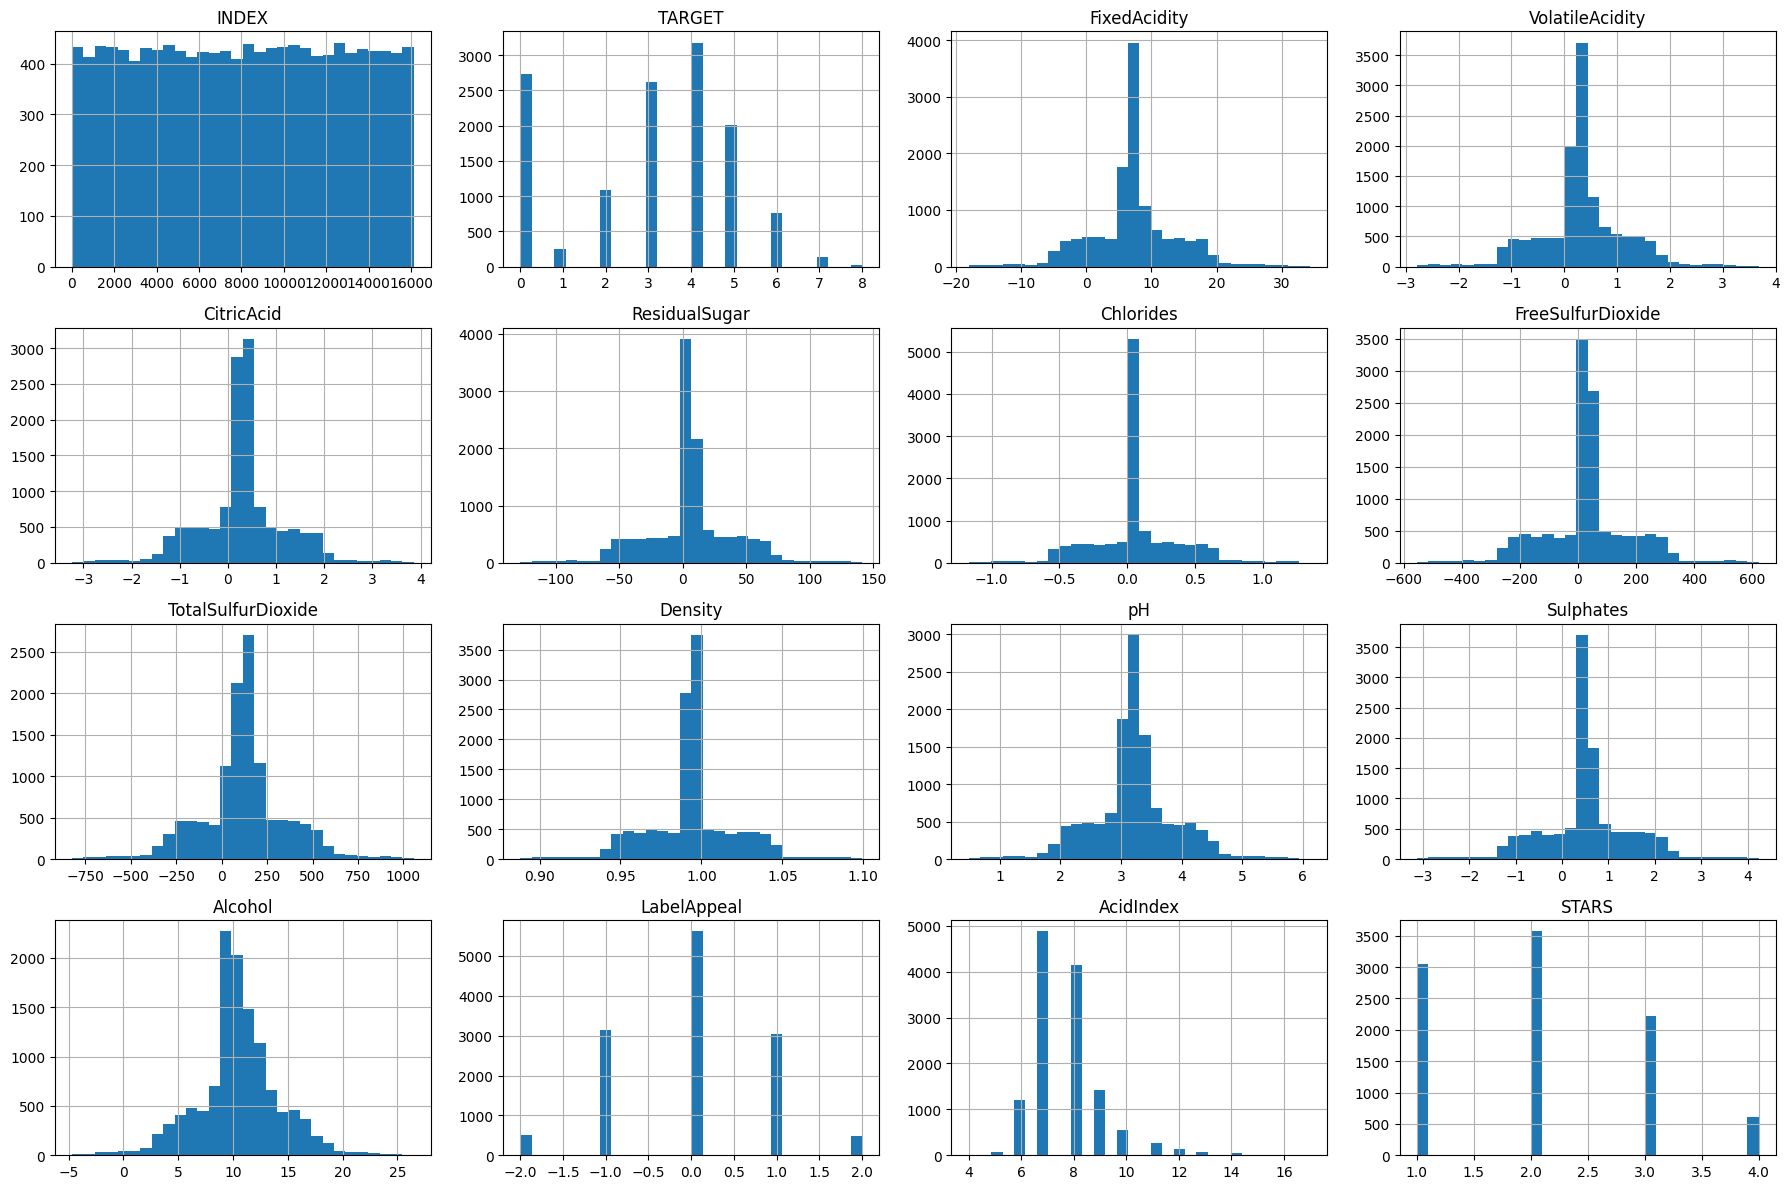

In [5]:
# plot histograms for all numeric columns
wine_df.hist(bins=30, figsize=(18, 12))
plt.tight_layout()
plt.show()

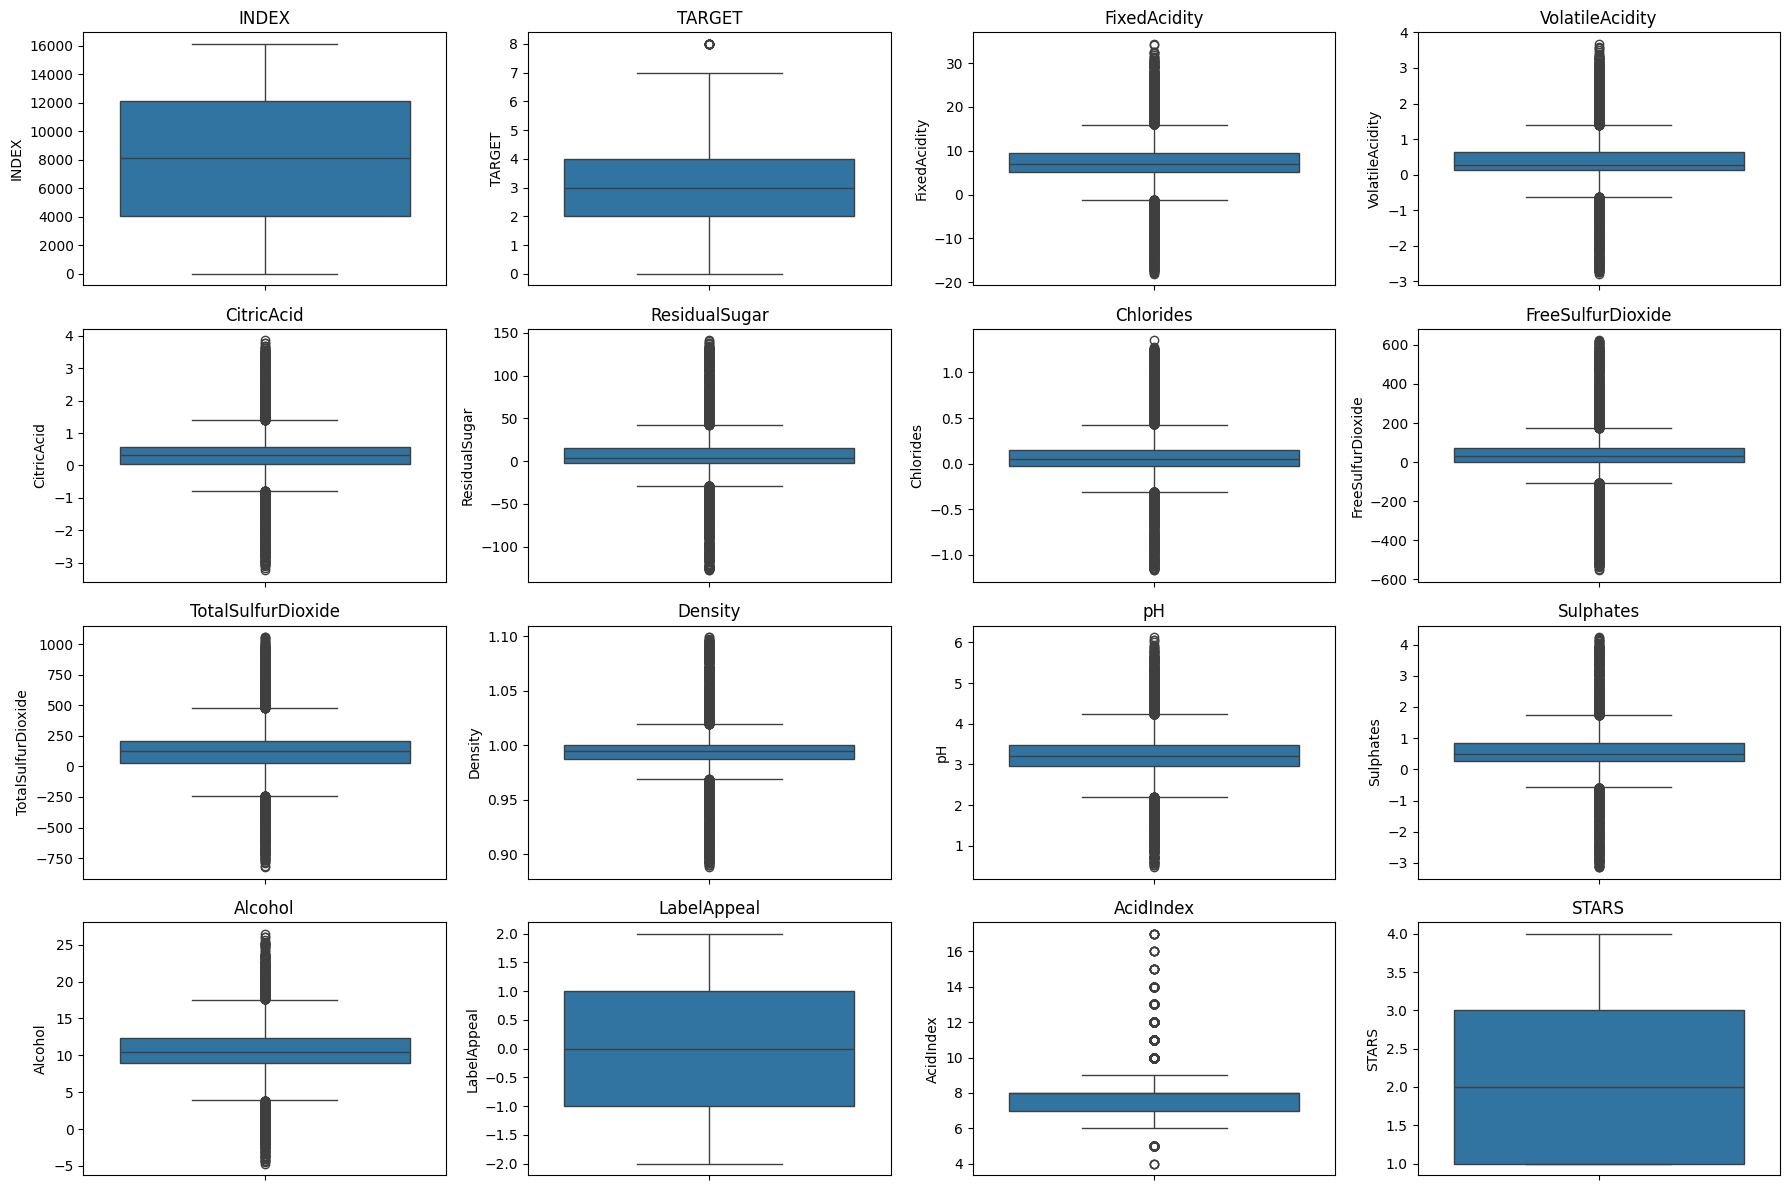

In [6]:
# plot boxplots for all numeric columns to check for outliers
plt.figure(figsize=(18, 12))
for i, col in enumerate(wine_df.select_dtypes(include=[np.number]).columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=wine_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

From the above, we can see that several columns have missing values and some contain negative or otherwise unusual values (e.g., negative acidity, negative sulfur dioxide, etc.). These will need to be addressed in the data preparation step.

## Data Integrity Issues and Preparation

Based on the EDA, there are several data integrity issues to address:
- Missing values in multiple columns
- Negative values in columns that should be non-negative (e.g., acidity, sulfur dioxide, etc.)
- Possible outliers and skewed distributions

We tackle missing values using imputation (mean for most numeric columns, mode for categorical), and set negative values to NaN before imputation for columns that should only have non-negative values, using the Scikitlearn library.

In [7]:
nonneg_cols = [
    "FixedAcidity", "VolatileAcidity", "CitricAcid", "ResidualSugar", "Chlorides",
    "FreeSulfurDioxide", "TotalSulfurDioxide", "Density", "pH", "Sulphates", "Alcohol",
    "LabelAppeal", "AcidIndex", "STARS"
]

# set negative values to NaN for these columns
for col in nonneg_cols:
    if col in wine_df.columns:
        wine_df.loc[wine_df[col] < 0, col] = np.nan

# impute missing values with mean for numeric columns, except for STARS, AcidIndex, and LabelAppeal which are discrete/categorical
cat_discrete_cols = ["STARS", "AcidIndex", "LabelAppeal"]
num_cols = [col for col in wine_df.select_dtypes(include=[np.number]).columns if col not in cat_discrete_cols]
imputer = SimpleImputer(strategy="mean")
wine_df[num_cols] = imputer.fit_transform(wine_df[num_cols])

# KNN imputation for STARS to ensure only valid integer values (1-5)
knn_imputer = KNNImputer(n_neighbors=5)
stars_imputed = knn_imputer.fit_transform(wine_df[["STARS"]])
# round to nearest valid integer and clip to valid range
stars_imputed = np.round(stars_imputed).astype(int)
stars_imputed = np.clip(stars_imputed, 1, 5)
wine_df["STARS"] = stars_imputed

# fill missing values in AcidIndex and LabelAppeal with mode (treat as categorical/discrete)
for col in ["AcidIndex", "LabelAppeal"]:
    if col in wine_df.columns:
        wine_df[col].fillna(wine_df[col].mode()[0], inplace=True)

# for any remaining non-numeric columns, fill missing with mode
for col in wine_df.select_dtypes(exclude=[np.number]).columns:
    wine_df[col].fillna(wine_df[col].mode()[0], inplace=True)

# check for missing values again
wine_df.isna().sum()

C:\Users\Mauri\AppData\Local\Temp\ipykernel_19748\1509544503.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wine_df[col].fillna(wine_df[col].mode()[0], inplace=True)


INDEX                 0
TARGET                0
FixedAcidity          0
VolatileAcidity       0
CitricAcid            0
ResidualSugar         0
Chlorides             0
FreeSulfurDioxide     0
TotalSulfurDioxide    0
Density               0
pH                    0
Sulphates             0
Alcohol               0
LabelAppeal           0
AcidIndex             0
STARS                 0
dtype: int64

After imputation, all missing values have been filled. Negative values in columns that should be non-negative have been replaced with the mean of the respective column. For the AcidIndex and LabelAppeal columns, which are discrete or categorical, missing values were filled using the mode (most frequent value). For the STARS column, which is a discrete rating with a large proportion of missing values (~3,000 out of 12,000), KNN imputation was used. 

Mode or median imputation were not ideal for Stars because with so many missing values, these methods would simply fill a large portion of the data with a single value, distorting the actual distribution and reducing variability. KNN imputation makes sure the similarity between samples to estimate missing values based on the patterns in the other features, and the results are rounded and clipped to ensure only valid integer ratings (1-5) are used. This approach avoids introducing nonsensical decimal values and is more robust than median or mode imputation when a large portion of the data is missing.

Below, we rerun EDA on the adjusted columns to compare the results before and after data preparation.

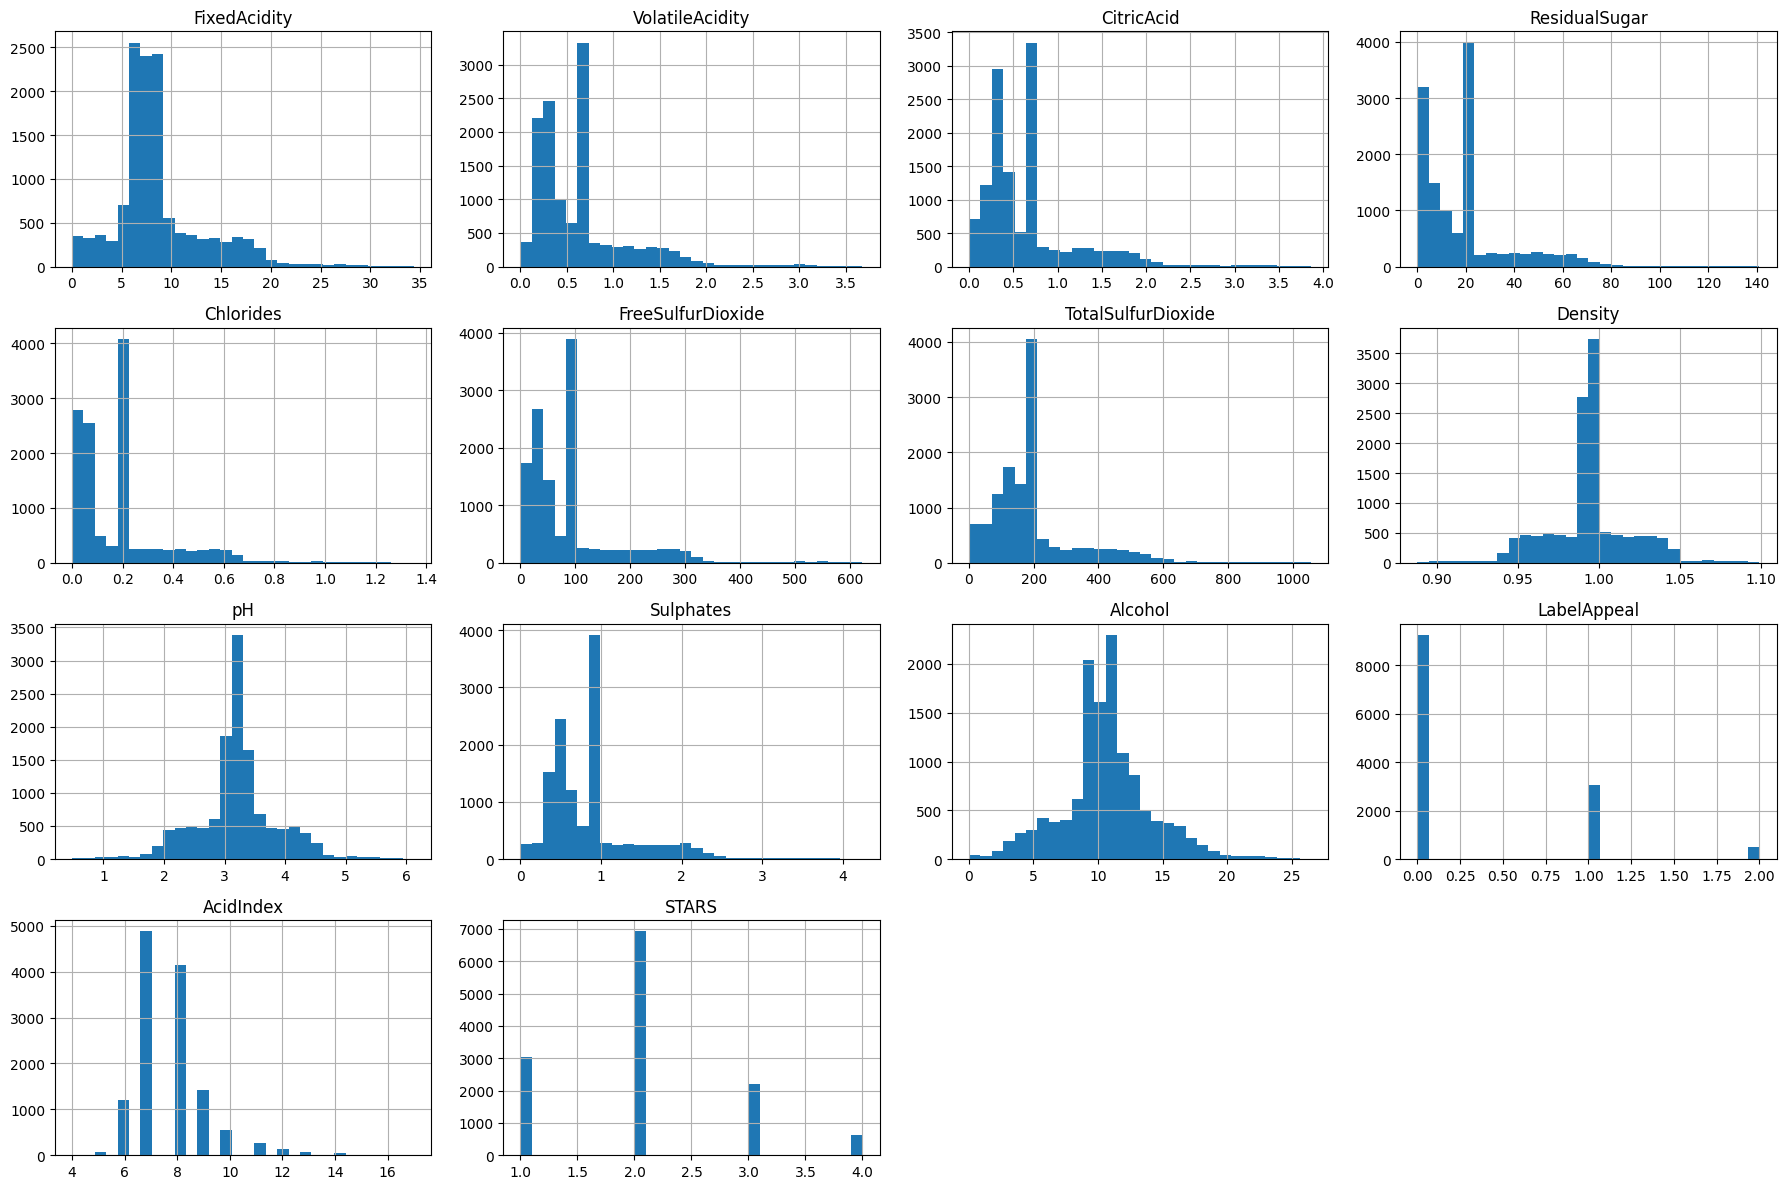

In [8]:
# replot histograms for the adjusted columns
adj_cols = [col for col in nonneg_cols if col in wine_df.columns]
wine_df[adj_cols].hist(bins=30, figsize=(18, 12))
plt.tight_layout()
plt.show()

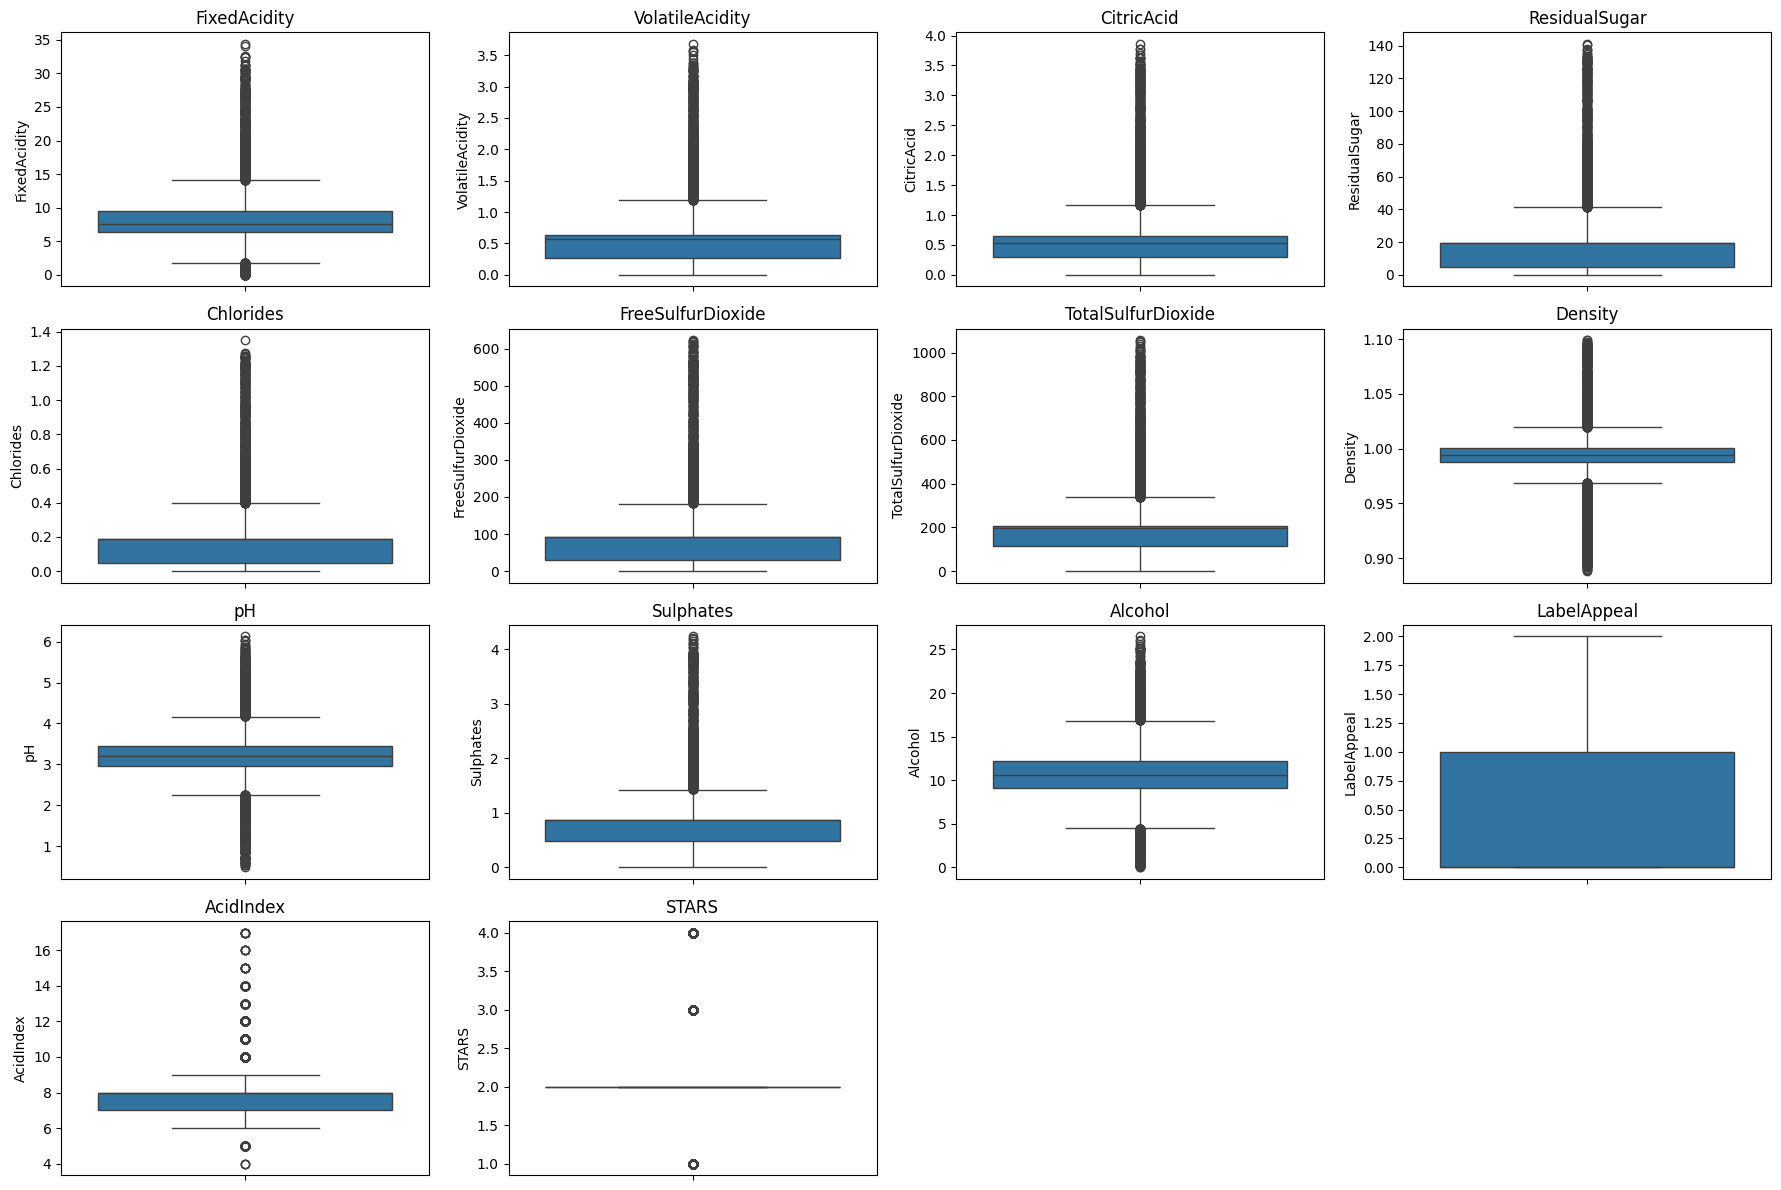

In [9]:
# replot boxplots for the adjusted columns
plt.figure(figsize=(18, 12))
for i, col in enumerate(adj_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=wine_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

## Prepped Data Review

The distributions of the adjusted columns now show fewer extreme outliers and no negative values. Imputation has filled in missing data, making the dataset more suitable for machine learning. However, some features remain a bit skewed.

## Conclusions

Through a combination of exploratory data analysis and data preparation, we have identified and addressed several data integrity issues in the wine dataset. Missing and invalid values were handled using imputation, and negative values in non-negative columns were corrected. The resulting dataset is now more suitable for use in machine learning models.